# Cat-astrophe

You've recently been hired by the city of Dogtopia to solve a growing problem with cats. You see, the residents of Dogtopia all hate cats, and many of them are allergic to cats. In recent years, cats have found their ways into the city gate, past the cat-traps, and started multiplying within the city perimeters. A team of rookie machine learning scientists developed a Convolutional Neural Network that take in images from security cameras and detect cats, however since they lack experience, they can't figure out why their neural network performs poorly. You, being a industry expert with many years of experience, are hired by the city to look over the scientists' work, and make the adjustments necessary to fix their neural network.

In [2]:
!pip install torch torchmetrics

You should consider upgrading via the '/home/zonyyu/Documents/Programming Projects/Project Files/M2MTech/Beginner AI Course/workshop-3-optimizing-your-learning-algorithm/env/bin/python3 -m pip install --upgrade pip' command.


In [3]:
! nvidia-smi

Tue Jun 15 09:28:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.31       Driver Version: 465.31       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P5    19W /  N/A |   1730MiB /  5934MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Visualizing our Dataset

The fine folks of Dogtopia has gathered what they describe as a "Large, Diverse Dataset" of cat and non-cat images. They have already done the processing for you.

In [10]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

features shape: (209, 64, 64, 3)
labels shape: (209, 1)


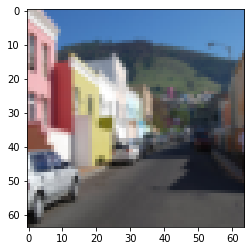

[0]


In [73]:
trainset = h5py.File("datasets/train_catvnoncat.h5")
testset = h5py.File("datasets/test_catvnoncat.h5")
#print(trainset.keys())

features = np.array(trainset["train_set_x"])
labels = np.array(trainset["train_set_y"]).reshape(-1, 1)

print(f"features shape: {features.shape}")
print(f"labels shape: {labels.shape}")


plt.imshow(features[1])
plt.show()
print(labels[1])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_cv, Y_train, Y_cv = train_test_split(features, labels, test_size=0.3)

print(X_train.shape)
print(Y_train.shape)
print(X_cv.shape)
print(Y_cv.shape)

(146, 64, 64, 3)
(146, 1)
(63, 64, 64, 3)
(63, 1)


In [28]:
def class_weights(Y_train):
    pos = np.sum(Y_train)
    neg = Y_train.shape[0] - pos
    print(f"Number of positive examples: {pos}")
    print(f"Number of negative examples: {neg}\n")
    w_pos = Y_train.shape[0]/(2*pos)
    w_neg = Y_train.shape[0]/(2*neg)
    print(f"weight of pos: {w_pos}")
    print(f"weight of neg: {w_neg}")
    posmask = Y_train * w_pos
    negmask = ~(Y_train.astype(bool)) * w_neg
    weights = posmask + negmask
    return weights

    
weights = class_weights(Y_train)

Number of positive examples: 53
Number of negative examples: 93

weight of pos: 1.3773584905660377
weight of neg: 0.7849462365591398


## Their Model

The scientists of Dogtopia presented you with their convolutional neural network they designed. It really looks like something developed by experienced computing scientists, so what can possibly go wrong?

In [33]:
import torch
from torch.nn import Module, Linear, BatchNorm1d, BatchNorm2d, Sigmoid, BCELoss, ReLU, Conv2d, MaxPool2d, Dropout
from torch.optim import SGD, Adam
from torchmetrics import Accuracy
from bokeh.layouts import Row

from bokeh.plotting import figure, show, output_notebook

class Classifier(Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.bnin = BatchNorm2d(3)
        self.conv1 = Conv2d(3, 24, kernel_size=7, padding=3)
        self.bn1 = BatchNorm2d(24)
        self.act1 = ReLU()
        self.mp1 = MaxPool2d(2)
        self.d1 = Dropout(0.5)
        
        self.conv2 = Conv2d(24, 48, kernel_size=5, padding=2)
        self.bn2 = BatchNorm2d(48)
        self.act2 = ReLU()
        self.mp2 = MaxPool2d(4)     
        self.d2 = Dropout(0.5)        
        
        self.fc3 = Linear(48*8*8, 200)
        self.bn3 = BatchNorm1d(200)
        self.act3 = ReLU()
        self.d3 = Dropout(0.5)

        self.fc4 = Linear(200, 100)
        self.bn4 = BatchNorm1d(100)
        self.act4 = ReLU()
        self.d4 = Dropout(0.5)       

        self.fc5 = Linear(100, 100)
        self.bn5 = BatchNorm1d(100)
        self.act5 = ReLU()
        self.d5 = Dropout(0.5) 

        self.out = Linear(100, 1)
        self.act6 = Sigmoid()

        self.train_costs = []
        self.val_costs = []
        self.train_acc = []
        self.val_acc = []
        self.epochs = None
    
    def forward(self, x):
        x = x.permute(0,3,1,2)
        
        x = self.bnin(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.mp1(x)
        x = self.d1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.mp2(x)
        x = self.d2(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.d3(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.d4(x)

        x = self.fc5(x)
        x = self.bn5(x)
        x = self.act5(x)
        x = self.d5(x)

        x = self.out(x)
        x = self.act6(x)

        return x


    
    def fit(self, X_train, Y_train, loss_fn, opt, X_cv=None, Y_cv=None, epochs=1):
        self.epochs = epochs    
        for i in range(epochs):   
            self.train()
            opt.zero_grad()
        
            Y_pred = self(X_train)
            cost = loss_fn(Y_pred, Y_train)
            
            acc = Accuracy().cuda()
            
            msg = f"Iter: {i}    loss: {cost.item(): .4f}    accuracy: {acc(torch.round(Y_pred).int(), Y_train.int()): .4f}    "
            self.train_costs.append(cost.item())
            self.train_acc.append(acc(torch.round(Y_pred).int(), Y_train.int()).item())

            if torch.is_tensor(X_cv) and torch.is_tensor(Y_cv):
                self.eval()
                Y_pred_val = self(X_cv)
                cost_val = BCELoss().cuda()(Y_pred_val, Y_cv)
                msg += f"cv_loss: {cost_val.item(): .4f}    cv_accuracy: {acc(torch.round(Y_pred_val).int(), Y_cv.int()): .4f}"
                self.val_costs.append(cost_val.item())
                self.val_acc.append(acc(torch.round(Y_pred_val).int(), Y_cv.int()).item())
                self.train()
            print(msg)
            
            cost.backward()
        
            opt.step()

    def disp_metrics(self):

        p = figure(width=500, height=300, x_axis_label="iterations", y_axis_label="cost", title="costs vs iterations", y_range=(0, 1.5))
        p.line(np.arange(1, self.epochs+1, 1),self.train_costs, color="blue")
        p.line(np.arange(1, self.epochs+1, 1), self.val_costs, color="red")

        p2 = figure(width=500, height=300, x_axis_label="iterations", y_axis_label="accuracy", title="accuracy vs iterations", y_range=(0.4, 1.05))
        p2.line(np.arange(1, self.epochs+1, 1), self.train_acc, color="blue")
        p2.line(np.arange(1, self.epochs+1, 1), self.val_acc, color="red")

        output_notebook()
        show(Row(p, p2))

In [34]:
input_dim, output_dim = (X_train.shape[1], 1)
LEARNING_RATE = 0.001
EPOCHS = 300

model_v1 = Classifier(input_dim, output_dim).cuda()
optimizer_v1 = Adam(model_v1.parameters(), lr=LEARNING_RATE)
criterion_v1 = BCELoss(weight=torch.from_numpy(weights).cuda()).cuda()

In [60]:
X_train_t = torch.from_numpy(X_train).float().cuda()
Y_train_t = torch.from_numpy(Y_train).float().cuda()
X_cv_t = torch.from_numpy(X_cv).float().cuda()
Y_cv_t = torch.from_numpy(Y_cv).float().cuda()

model_v1.fit(X_train_t, Y_train_t, criterion_v1, optimizer_v1, X_cv=X_cv_t, Y_cv=Y_cv_t, epochs=EPOCHS)
model_v1.disp_metrics()

Iter: 0    loss:  0.0122    accuracy:  0.9932    cv_loss:  1.8480    cv_accuracy:  0.6667
Iter: 1    loss:  0.0022    accuracy:  1.0000    cv_loss:  1.9809    cv_accuracy:  0.6349
Iter: 2    loss:  0.0068    accuracy:  1.0000    cv_loss:  2.0897    cv_accuracy:  0.6349
Iter: 3    loss:  0.0109    accuracy:  0.9932    cv_loss:  2.1298    cv_accuracy:  0.6190
Iter: 4    loss:  0.0103    accuracy:  0.9932    cv_loss:  2.2534    cv_accuracy:  0.6032
Iter: 5    loss:  0.0076    accuracy:  1.0000    cv_loss:  2.2945    cv_accuracy:  0.5873
Iter: 6    loss:  0.0028    accuracy:  1.0000    cv_loss:  2.2635    cv_accuracy:  0.6032
Iter: 7    loss:  0.0106    accuracy:  0.9932    cv_loss:  2.2014    cv_accuracy:  0.5873
Iter: 8    loss:  0.0043    accuracy:  1.0000    cv_loss:  2.0274    cv_accuracy:  0.6190
Iter: 9    loss:  0.0227    accuracy:  0.9932    cv_loss:  1.8629    cv_accuracy:  0.6508
Iter: 10    loss:  0.0088    accuracy:  0.9932    cv_loss:  1.6719    cv_accuracy:  0.7143
Iter: 11 

Iter: 92    loss:  0.0188    accuracy:  0.9932    cv_loss:  1.8022    cv_accuracy:  0.6349
Iter: 93    loss:  0.0045    accuracy:  1.0000    cv_loss:  1.7979    cv_accuracy:  0.6667
Iter: 94    loss:  0.0035    accuracy:  1.0000    cv_loss:  1.8124    cv_accuracy:  0.6667
Iter: 95    loss:  0.0022    accuracy:  1.0000    cv_loss:  1.8245    cv_accuracy:  0.6667
Iter: 96    loss:  0.0057    accuracy:  1.0000    cv_loss:  1.8356    cv_accuracy:  0.6667
Iter: 97    loss:  0.0022    accuracy:  1.0000    cv_loss:  1.8461    cv_accuracy:  0.6825
Iter: 98    loss:  0.0033    accuracy:  1.0000    cv_loss:  1.8403    cv_accuracy:  0.6667
Iter: 99    loss:  0.0020    accuracy:  1.0000    cv_loss:  1.8491    cv_accuracy:  0.6667
Iter: 100    loss:  0.0118    accuracy:  1.0000    cv_loss:  1.8545    cv_accuracy:  0.6667
Iter: 101    loss:  0.0044    accuracy:  1.0000    cv_loss:  1.8608    cv_accuracy:  0.6667
Iter: 102    loss:  0.0033    accuracy:  1.0000    cv_loss:  1.8485    cv_accuracy:  0.6

Iter: 182    loss:  0.0020    accuracy:  1.0000    cv_loss:  1.9347    cv_accuracy:  0.6984
Iter: 183    loss:  0.0012    accuracy:  1.0000    cv_loss:  1.9460    cv_accuracy:  0.6984
Iter: 184    loss:  0.0013    accuracy:  1.0000    cv_loss:  1.9535    cv_accuracy:  0.6984
Iter: 185    loss:  0.0010    accuracy:  1.0000    cv_loss:  1.9647    cv_accuracy:  0.6984
Iter: 186    loss:  0.0010    accuracy:  1.0000    cv_loss:  1.9687    cv_accuracy:  0.6984
Iter: 187    loss:  0.0010    accuracy:  1.0000    cv_loss:  1.9772    cv_accuracy:  0.6984
Iter: 188    loss:  0.0008    accuracy:  1.0000    cv_loss:  1.9866    cv_accuracy:  0.6984
Iter: 189    loss:  0.0017    accuracy:  1.0000    cv_loss:  1.9896    cv_accuracy:  0.6984
Iter: 190    loss:  0.0013    accuracy:  1.0000    cv_loss:  1.9782    cv_accuracy:  0.6984
Iter: 191    loss:  0.0012    accuracy:  1.0000    cv_loss:  1.9642    cv_accuracy:  0.6984
Iter: 192    loss:  0.0016    accuracy:  1.0000    cv_loss:  1.9713    cv_accura

Iter: 272    loss:  0.0021    accuracy:  1.0000    cv_loss:  1.6251    cv_accuracy:  0.7460
Iter: 273    loss:  0.0033    accuracy:  1.0000    cv_loss:  1.6637    cv_accuracy:  0.7460
Iter: 274    loss:  0.0060    accuracy:  1.0000    cv_loss:  1.6794    cv_accuracy:  0.7460
Iter: 275    loss:  0.0023    accuracy:  1.0000    cv_loss:  1.7095    cv_accuracy:  0.7460
Iter: 276    loss:  0.0023    accuracy:  1.0000    cv_loss:  1.7582    cv_accuracy:  0.7302
Iter: 277    loss:  0.0009    accuracy:  1.0000    cv_loss:  1.8190    cv_accuracy:  0.7302
Iter: 278    loss:  0.0011    accuracy:  1.0000    cv_loss:  1.8554    cv_accuracy:  0.7143
Iter: 279    loss:  0.0010    accuracy:  1.0000    cv_loss:  1.8853    cv_accuracy:  0.7143
Iter: 280    loss:  0.0013    accuracy:  1.0000    cv_loss:  1.9010    cv_accuracy:  0.7143
Iter: 281    loss:  0.0011    accuracy:  1.0000    cv_loss:  1.9112    cv_accuracy:  0.6984
Iter: 282    loss:  0.0011    accuracy:  1.0000    cv_loss:  1.9272    cv_accura

Loading BokehJS ...

## Your Take

While the machine learning model is state-of-the-art, you realize that the scientists really do not know how to analyze training and cross validation cost! While their model is doing very well on the training set, it **generalizes very poorly to the cross validation set**. See if you can best their attempt by applying some **L2 Regularization**.

In [58]:
input_dim, output_dim = (X_train.shape[1], 1)
LEARNING_RATE = 0.001
EPOCHS = 300
L2 = 0.6

model_v2 = Classifier(input_dim, output_dim).cuda()
optimizer_v2 = Adam(model_v2.parameters(), lr=LEARNING_RATE, weight_decay=L2)
criterion_v2 = BCELoss(weight=torch.from_numpy(weights).cuda()).cuda()

In [59]:
X_train_t = torch.from_numpy(X_train).float().cuda()
Y_train_t = torch.from_numpy(Y_train).float().cuda()
X_cv_t = torch.from_numpy(X_cv).float().cuda()
Y_cv_t = torch.from_numpy(Y_cv).float().cuda()

model_v2.fit(X_train_t, Y_train_t, criterion_v2, optimizer_v2, X_cv=X_cv_t, Y_cv=Y_cv_t, epochs=EPOCHS)
model_v2.disp_metrics()

Iter: 0    loss:  0.7084    accuracy:  0.5616    cv_loss:  0.6919    cv_accuracy:  0.5238
Iter: 1    loss:  0.6844    accuracy:  0.5753    cv_loss:  0.6956    cv_accuracy:  0.3492
Iter: 2    loss:  0.6822    accuracy:  0.6027    cv_loss:  0.6963    cv_accuracy:  0.3175
Iter: 3    loss:  0.6804    accuracy:  0.5822    cv_loss:  0.6971    cv_accuracy:  0.3016
Iter: 4    loss:  0.6971    accuracy:  0.5548    cv_loss:  0.6975    cv_accuracy:  0.3016
Iter: 5    loss:  0.7091    accuracy:  0.5274    cv_loss:  0.6988    cv_accuracy:  0.3016
Iter: 6    loss:  0.6892    accuracy:  0.5479    cv_loss:  0.6997    cv_accuracy:  0.3016
Iter: 7    loss:  0.6600    accuracy:  0.5822    cv_loss:  0.7014    cv_accuracy:  0.3016
Iter: 8    loss:  0.6531    accuracy:  0.6233    cv_loss:  0.7044    cv_accuracy:  0.3016
Iter: 9    loss:  0.6523    accuracy:  0.5685    cv_loss:  0.7087    cv_accuracy:  0.3016
Iter: 10    loss:  0.6636    accuracy:  0.5685    cv_loss:  0.7148    cv_accuracy:  0.3016
Iter: 11 

Iter: 92    loss:  0.1456    accuracy:  0.9932    cv_loss:  0.4420    cv_accuracy:  0.8413
Iter: 93    loss:  0.1370    accuracy:  1.0000    cv_loss:  0.4791    cv_accuracy:  0.7778
Iter: 94    loss:  0.1525    accuracy:  0.9863    cv_loss:  0.4764    cv_accuracy:  0.7778
Iter: 95    loss:  0.1338    accuracy:  1.0000    cv_loss:  0.4486    cv_accuracy:  0.7937
Iter: 96    loss:  0.1573    accuracy:  0.9863    cv_loss:  0.5011    cv_accuracy:  0.7619
Iter: 97    loss:  0.1328    accuracy:  0.9932    cv_loss:  0.5598    cv_accuracy:  0.7460
Iter: 98    loss:  0.1376    accuracy:  0.9932    cv_loss:  0.5844    cv_accuracy:  0.6825
Iter: 99    loss:  0.1398    accuracy:  0.9932    cv_loss:  0.5970    cv_accuracy:  0.6984
Iter: 100    loss:  0.1313    accuracy:  0.9932    cv_loss:  0.5330    cv_accuracy:  0.7302
Iter: 101    loss:  0.1353    accuracy:  0.9726    cv_loss:  0.4556    cv_accuracy:  0.7778
Iter: 102    loss:  0.1445    accuracy:  0.9795    cv_loss:  0.5492    cv_accuracy:  0.7

Iter: 182    loss:  0.1392    accuracy:  0.9795    cv_loss:  0.4407    cv_accuracy:  0.8254
Iter: 183    loss:  0.1528    accuracy:  0.9795    cv_loss:  0.6055    cv_accuracy:  0.7302
Iter: 184    loss:  0.1499    accuracy:  0.9863    cv_loss:  0.7036    cv_accuracy:  0.6825
Iter: 185    loss:  0.1610    accuracy:  0.9726    cv_loss:  0.5418    cv_accuracy:  0.7619
Iter: 186    loss:  0.1495    accuracy:  0.9795    cv_loss:  0.3872    cv_accuracy:  0.8571
Iter: 187    loss:  0.1703    accuracy:  0.9452    cv_loss:  0.3745    cv_accuracy:  0.8095
Iter: 188    loss:  0.2163    accuracy:  0.9315    cv_loss:  0.4219    cv_accuracy:  0.8254
Iter: 189    loss:  0.1543    accuracy:  0.9863    cv_loss:  0.3848    cv_accuracy:  0.8730
Iter: 190    loss:  0.2143    accuracy:  0.9452    cv_loss:  0.4033    cv_accuracy:  0.8730
Iter: 191    loss:  0.1569    accuracy:  0.9863    cv_loss:  0.4793    cv_accuracy:  0.8095
Iter: 192    loss:  0.1828    accuracy:  0.9795    cv_loss:  0.5126    cv_accura

Iter: 273    loss:  0.1473    accuracy:  0.9863    cv_loss:  0.3817    cv_accuracy:  0.8571
Iter: 274    loss:  0.1502    accuracy:  0.9932    cv_loss:  0.4058    cv_accuracy:  0.8413
Iter: 275    loss:  0.1478    accuracy:  0.9863    cv_loss:  0.3903    cv_accuracy:  0.8571
Iter: 276    loss:  0.1510    accuracy:  0.9932    cv_loss:  0.4424    cv_accuracy:  0.7937
Iter: 277    loss:  0.1562    accuracy:  0.9795    cv_loss:  0.6333    cv_accuracy:  0.6984
Iter: 278    loss:  0.1754    accuracy:  0.9795    cv_loss:  0.6540    cv_accuracy:  0.6984
Iter: 279    loss:  0.1614    accuracy:  0.9726    cv_loss:  0.4482    cv_accuracy:  0.7937
Iter: 280    loss:  0.1454    accuracy:  0.9932    cv_loss:  0.3447    cv_accuracy:  0.8889
Iter: 281    loss:  0.1572    accuracy:  0.9863    cv_loss:  0.3687    cv_accuracy:  0.8730
Iter: 282    loss:  0.1499    accuracy:  0.9863    cv_loss:  0.3769    cv_accuracy:  0.8889
Iter: 283    loss:  0.1779    accuracy:  0.9863    cv_loss:  0.4010    cv_accura

Loading BokehJS ...

## Testing Your Model

Now it's time to report back to the city of Dogtopia on your results! You use the testing data they gave you and demoed your classifier.

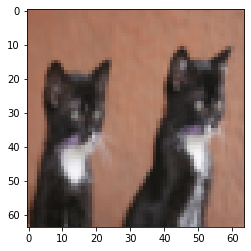

0.7841997146606445 	Prediction:  Cat


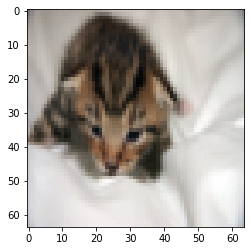

0.7652854919433594 	Prediction:  Cat


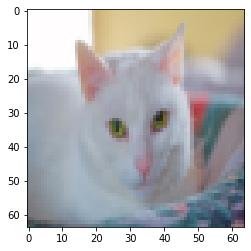

0.6635295748710632 	Prediction:  Cat


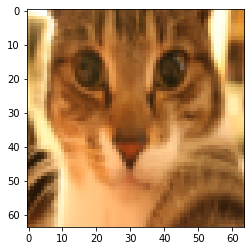

0.7647495865821838 	Prediction:  Cat


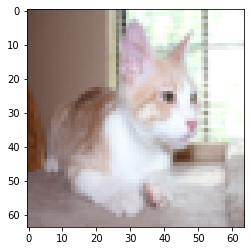

0.8045304417610168 	Prediction:  Cat


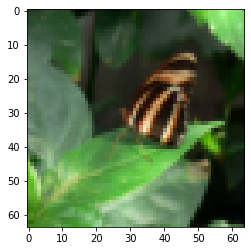

0.14137057960033417 	Prediction:  Non-Cat


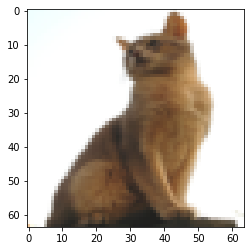

0.6901149749755859 	Prediction:  Cat


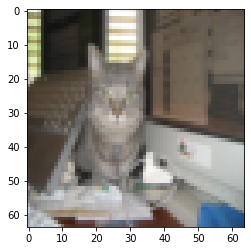

0.8338398337364197 	Prediction:  Cat


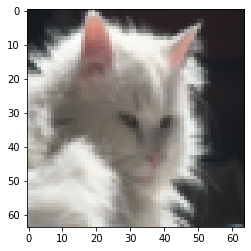

0.9258127808570862 	Prediction:  Cat


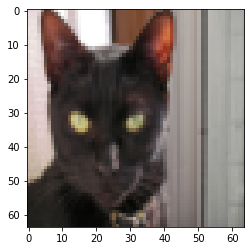

0.8987752199172974 	Prediction:  Cat


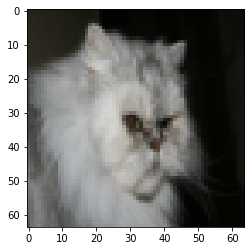

0.8147404193878174 	Prediction:  Cat


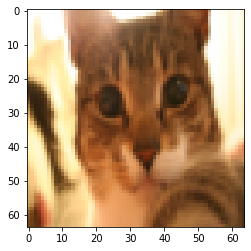

0.5300650000572205 	Prediction:  Cat


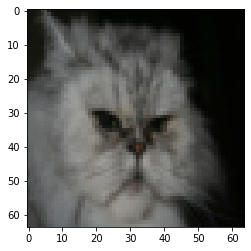

0.8409104943275452 	Prediction:  Cat


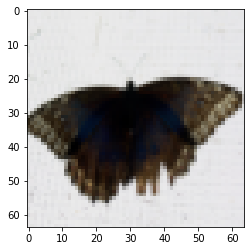

0.5742246508598328 	Prediction:  Cat


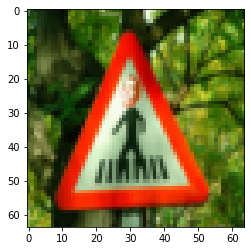

0.17749066650867462 	Prediction:  Non-Cat


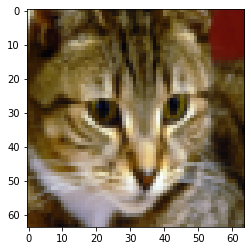

0.22777175903320312 	Prediction:  Non-Cat


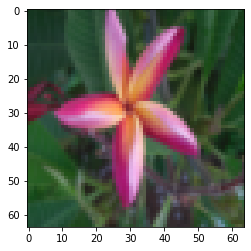

0.1487283855676651 	Prediction:  Non-Cat


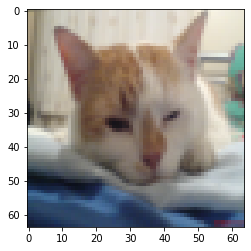

0.7333466410636902 	Prediction:  Cat


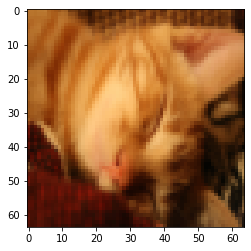

0.38984358310699463 	Prediction:  Non-Cat


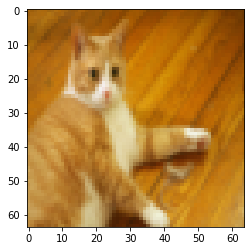

0.21397706866264343 	Prediction:  Non-Cat


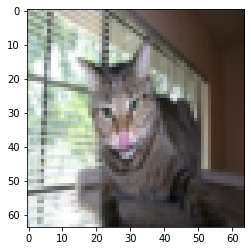

0.20798274874687195 	Prediction:  Non-Cat


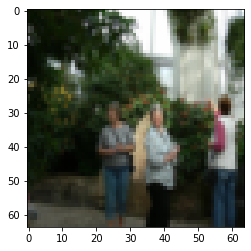

0.1850326806306839 	Prediction:  Non-Cat


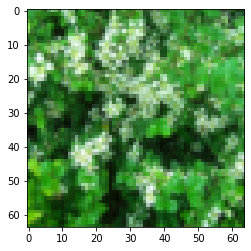

0.15385130047798157 	Prediction:  Non-Cat


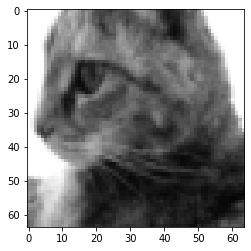

0.7850699424743652 	Prediction:  Cat


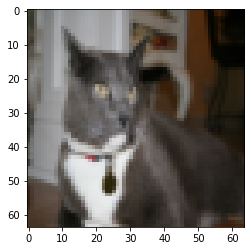

0.8588900566101074 	Prediction:  Cat


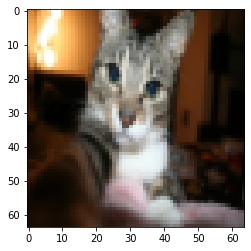

0.7580166459083557 	Prediction:  Cat


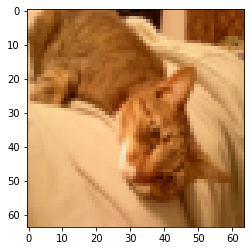

0.891796886920929 	Prediction:  Cat


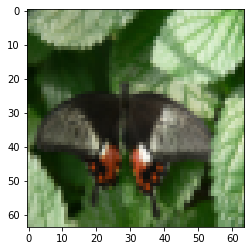

0.15030410885810852 	Prediction:  Non-Cat


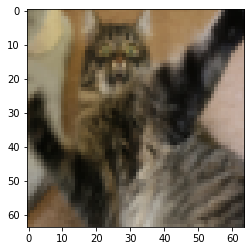

0.8158187866210938 	Prediction:  Cat


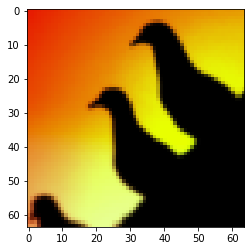

0.16301722824573517 	Prediction:  Non-Cat


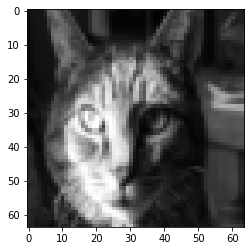

0.8061529994010925 	Prediction:  Cat


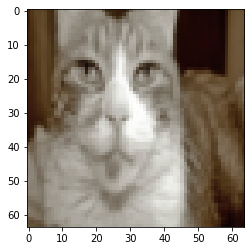

0.9256435036659241 	Prediction:  Cat


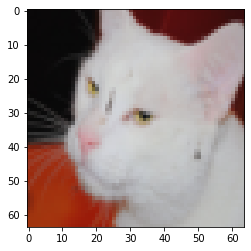

0.1964418888092041 	Prediction:  Non-Cat


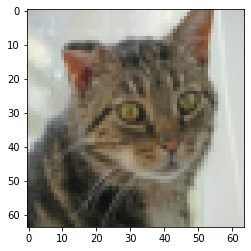

0.6066280603408813 	Prediction:  Cat


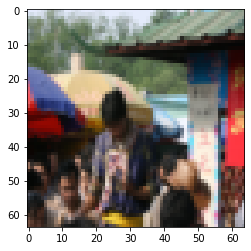

0.16887308657169342 	Prediction:  Non-Cat


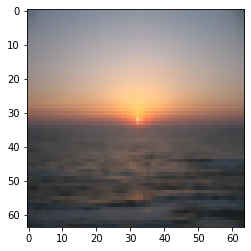

0.1426473706960678 	Prediction:  Non-Cat


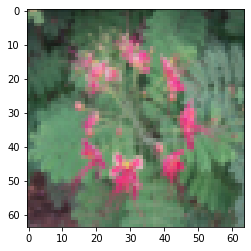

0.1497717648744583 	Prediction:  Non-Cat


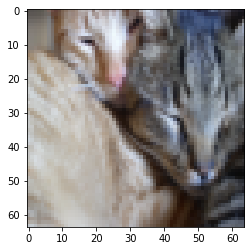

0.8726587891578674 	Prediction:  Cat


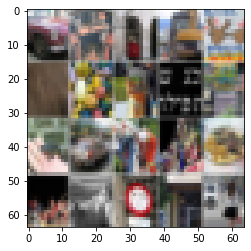

0.17890948057174683 	Prediction:  Non-Cat


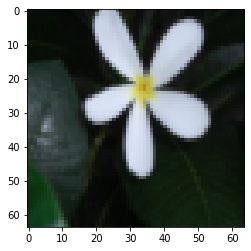

0.22179563343524933 	Prediction:  Non-Cat


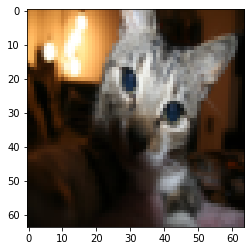

0.6212652325630188 	Prediction:  Cat


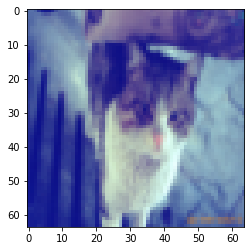

0.7091822028160095 	Prediction:  Cat


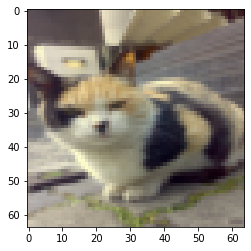

0.6245724558830261 	Prediction:  Cat


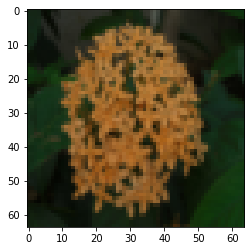

0.14372466504573822 	Prediction:  Non-Cat


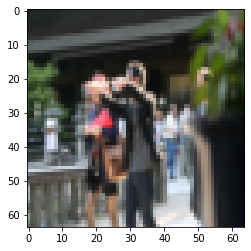

0.16146261990070343 	Prediction:  Non-Cat


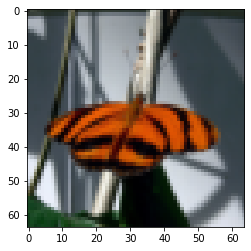

0.15811821818351746 	Prediction:  Non-Cat


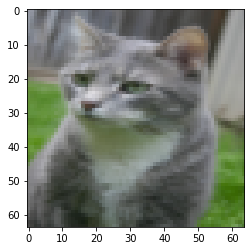

0.6474542021751404 	Prediction:  Cat


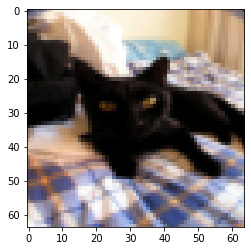

0.6349709630012512 	Prediction:  Cat


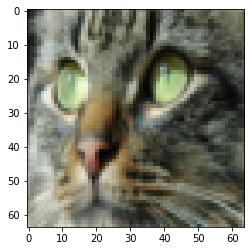

0.17890776693820953 	Prediction:  Non-Cat


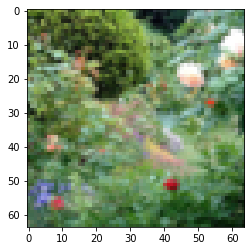

0.14570993185043335 	Prediction:  Non-Cat


In [69]:
#print(testset.keys())
inputs = np.array(testset['test_set_x'])
inputs_t = torch.from_numpy(inputs).float().cuda()

model_v2.eval()

prediction = model_v2(inputs_t)

for i in range(inputs.shape[0]):
    plt.imshow(inputs[i])
    plt.show()
    print(prediction[i].item(), "\tPrediction: ", "Cat" if prediction[i].item() > 0.5 else "Non-Cat" )

## Conclusion

The city of Dogtopia are thoroughly impressed, and offered you a permanent job there. You politely declined their offer (since you like cats), however you agreed to spend a few days explaining to the scientists the importance of **deciphering bias and variance problems from training and validation loss**, as well as **fixing variance problems using regularization.**